In [10]:
# Import PyTorch

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import SGD

# Import other packages

import matplotlib.pyplot as plt
import numpy as np

In [11]:
# Define the hyper-parameters of the model

input_size = 784
hidden_size = 512
num_classes = 10
num_epochs = 20
batch_size = 100
learning_rate = 0.05

In [12]:
# Import the MNIST dataset as two separate datasets

train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

validation_dataset = torchvision.datasets.MNIST(root='data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Create the data loader for training
train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Create the data loader for validating

validation_dataset_loader = DataLoader(dataset=validation_dataset, batch_size=1, shuffle=False) 

In [13]:
# Defining a FC neural network

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size) 
        self.fc3 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        x = self.fc1(x)
        x = x.relu()
        x = self.fc2(x)
        x = x.relu()
        x = self.fc3(x)
        return x
    
def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

model = NeuralNet(input_size, hidden_size, num_classes)
ReLU_glorot_init(model)

In [14]:
# Use CrossEntropyLoss as its bounded between 0-1

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=learning_rate) 

In [15]:
# Training Epoch

def train_epoch():
    for i, (images, labels) in enumerate(train_dataset_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28)
        labels = labels
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

    return loss.item()

# Obtain empirical risk of model from the validation set

def empirical_validation_risk(data_loader):
    loss_list=[]
    with torch.no_grad():
        for image, label in data_loader:
            image = image.reshape(-1, 28*28)
            outputs = model(image)
            loss_list.append(criterion(outputs, label).item())
    return sum(loss_list)/(len(loss_list))
    
def empirical_validation_risk_with_list(data_loader):
    loss_list=[]
    with torch.no_grad():
        for image, label in data_loader:
            image = image.reshape(-1, 28*28)
            outputs = model(image)
            loss_list.append(criterion(outputs, label).item())
    return sum(loss_list)/(len(loss_list)), loss_list
    

The validation approach we take here is to use the validation set to choose the best model amongst those that achieve a loss of less than $0.05$ on the training set. 

In [16]:
# Train the model

max_validation_loss=1

training_epochs=0
validation_epochs=0
while training_epochs<10 or validation_epochs<10:
    loss=train_epoch()
    if loss<0.05:
        validation_loss=empirical_validation_risk(validation_dataset_loader)
        if validation_loss<max_validation_loss:
            torch.save(model, './models/validated_model')
            max_validation_loss=validation_loss
        validation_epochs+=1
        print ('Epoch {}, Loss: {}, Validation Loss: {}'.format(training_epochs+validation_epochs, loss, validation_loss))
    else:
        training_epochs+=1
        print ('Epoch {}, Loss: {}'.format(training_epochs+validation_epochs, loss))

Epoch 1, Loss: 0.32604607939720154
Epoch 2, Loss: 0.13905131816864014
Epoch 3, Loss: 0.12224797904491425
Epoch 4, Loss: 0.09713274985551834
Epoch 5, Loss: 0.15487311780452728
Epoch 6, Loss: 0.07585600018501282
Epoch 7, Loss: 0.155830517411232
Epoch 8, Loss: 0.021093660965561867, Validation Loss: 0.09443628822815221
Epoch 9, Loss: 0.18328773975372314
Epoch 10, Loss: 0.1349162459373474
Epoch 11, Loss: 0.08566947281360626
Epoch 12, Loss: 0.03461359813809395, Validation Loss: 0.07400895195673445
Epoch 13, Loss: 0.05116581916809082
Epoch 14, Loss: 0.01345796324312687, Validation Loss: 0.0699172538650834
Epoch 15, Loss: 0.043880220502614975, Validation Loss: 0.07027935049918876
Epoch 16, Loss: 0.042903367429971695, Validation Loss: 0.06991082166417366
Epoch 17, Loss: 0.03459509089589119, Validation Loss: 0.06634650884920269
Epoch 18, Loss: 0.044996291399002075, Validation Loss: 0.0686441401755661
Epoch 19, Loss: 0.028151974081993103, Validation Loss: 0.06695834115008892
Epoch 20, Loss: 0.044

In [17]:
model = torch.load('./models/validated_model')

In [18]:
# delta and Gamma_squared chosen reasonably, C chosen for worst-case, 

delta=0.1
gamma_squared=0.05**2
C=1

validation_risk_value,validation_risk_list=empirical_validation_risk_with_list(validation_dataset_loader)
m_val=len(validation_risk_list)

# Calculate bound on the on the expected risk

generalization_bound=validation_risk_value+(2*C*np.log(validation_epochs/delta))/(3*m_val)+np.sqrt((2*gamma_squared)*np.log(validation_epochs/delta)/m_val)

print(generalization_bound)

0.06639129309437705


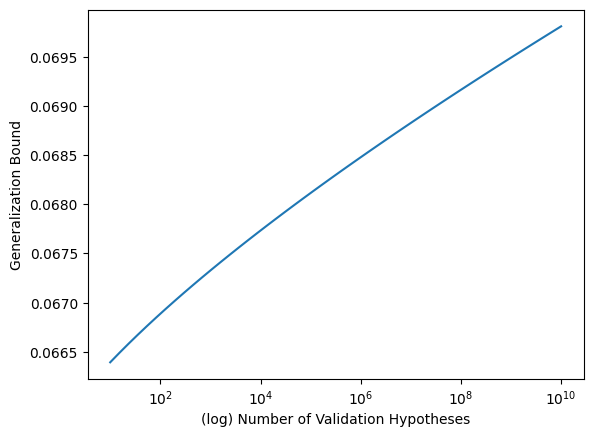

In [19]:
f_val=np.logspace(1,10,num=50)
plt.plot(f_val,validation_risk_value+(2*C*np.log(f_val/delta))/(3*m_val)+np.sqrt((2*gamma_squared)*np.log(f_val/delta)/m_val))
plt.xscale('log')
plt.ylabel('Generalization Bound')
plt.xlabel('(log) Number of Validation Hypotheses')
plt.savefig('plots/validation_bound.png')
plt.show()